<a href="https://colab.research.google.com/github/Swicano/IntroML_NBs/blob/master/Glorot_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy import *
import matplotlib.pyplot as plt # for plotting

### Define a training and validation batch generation method, dependent on problem type 
   F(x,y) \\
   single image compression \\
   or multi image classification

---

####   F(x,y) 

---

In [0]:
#define a function with 2 inputs and one output (you could do more, but the viz...)

# heres two examples
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(exp(-5*r2)*abs(x1+x0))
#def myFunc(x0,x1):
#    x = sin(10*x0)
#    y = cos(12*x1)
#    return((x*y+1)/2)


Since this is algorithmic, we need to create a validation set, as well as a training set

In [0]:
# validation -> create a set that covers our whole space (-1,1) evenly
M=200 # how many points to cover in each direction
# Generate a 'mesh grid', i.e. x,y values in an image
v0,v1=meshgrid(linspace(-1,1,M),linspace(-1,1,M))
v0flat=v0.flatten() # make 1D array out of 2D array
v1flat=v1.flatten() # that means: MxM matrix becomes M^2 vector
batchsize=shape(v0flat)[0] # number of samples = number of pixels
val_y_in=zeros([batchsize,2])
val_y_in[:,0]=v0flat # fill first component (index 0)
val_y_in[:,1]=v1flat # fill second component
val_y_targ = myFunc(val_y_in[:,0],val_y_in[:,1])


#y_2Dn=reshape(val_y_targ,[M,M])
#plt.figure(figsize=[7,7])
#plt.imshow(y_2Dn,origin='lower')
#plt.show()

And a function to create training batches

In [0]:
def make_batch(batchsize = 1000):
  inputs=random.uniform(low=-1,high=+1,size=[batchsize,2])
  targets=zeros([batchsize,1]) # must have right dimensions
  targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
  return(inputs,targets)
#print(shape(make_batch()[0]))

####   Single Image
  Copied from "KerasMultiLayer_ImageCompression.ipynb"

In [0]:
# we need to import the image from the internet and use it to make batches
from scipy import ndimage # for image loading/processing
from scipy import misc  # misc.imread is deprecated, use
import imageio          # imageio.imread instead

Load the pixel image

In [0]:
# load the pixel image!
face = imageio.imread('https://raw.githubusercontent.com/Swicano/IntroML_NBs/master/smily.jpg')
pixel_image=transpose(face[:,:,0]) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=pixel_image.min()
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=shape(pixel_image)[0] # assuming a square image!

define a function with 2 inputs and one output which samples the image

In [0]:
# the function we want to have (desired outcome)
def myFunc(x0,x1):
    global pixel_image, Npixels
    # convert to integer coordinates (assuming input is 0..1)
    x0int=((x0+1)/2*Npixels*0.9999).astype(dtype='int')
    x1int=((x1+1)/2*Npixels*0.9999).astype(dtype='int')
    return(pixel_image[x0int,x1int]) # extract color values at these pixels

validation -> create a set that covers our whole space (-1,1) evenly (since we have a functional input we can cover the whole space evenly)

In [0]:
# Same as above, but make sure we sample the space with the right bounds
M=200 # how many points to cover in each direction
# Generate a 'mesh grid', i.e. x,y values in an image
v0,v1=meshgrid(linspace(-1,1,M),linspace(-1,1,M))
v0flat=v0.flatten() # make 1D array out of 2D array
v1flat=v1.flatten() # that means: MxM matrix becomes M^2 vector
batchsize=shape(v0flat)[0] # number of samples = number of pixels
val_y_in=zeros([batchsize,2])
val_y_in[:,0]=v0flat # fill first component (index 0)
val_y_in[:,1]=v1flat # fill second component
val_y_targ = myFunc(val_y_in[:,0],val_y_in[:,1])


#y_2Dn=reshape(val_y_targ,[M,M])
#plt.figure(figsize=[7,7])
#plt.imshow(y_2Dn,origin='lower')
#plt.show()

And a function to create training batches

In [0]:
def make_batch(batchsize = 1000):
  inputs=random.uniform(low=-1,high=+1,size=[batchsize,2])
  targets=zeros([batchsize,1]) # must have right dimensions
  targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
  return(inputs,targets)
#print(shape(make_batch()[0]))

####   Multi Image categorization

### Setup a neural network using Keras
  or the old way, for giggles

#### The old way

In [0]:
class SimpleNN:
  
  # here we init the class variables and set up the structure, as well 
  #    the nonlinear and Cost function if ones are passed
  #    neur is a list of ints, where each int is the number of neurons in a layer
  #    and the position in the list is that layer number
  def __init__(self, neur , f=None, C=None, Xav=1 ):
    self.neurons = neur
    self.layers = len(neur)
    
    # the default nonlinear function is a sigmoid
    if f is None:
      def f(x):
        val=1/(1+exp(-x))
        return(val,exp(-x)*(val**2))
      self.nonlin = f
    else:
      self.nonlin = f
    
    # the default cost function is norm^2
    if C is None:
      def C(yout,ytarget):
        diff = 1/(2*shape(yout)[0])*((yout-ytarget)**2)
        ddiff = 1/(shape(yout)[0])*(yout-ytarget)
        return(diff,ddiff)
      self.fcost = C
    else:
      self.fcost = C
        
    self.y_n = []
    self.dy_n = []
    self.z_n = []
    self.biases = []
    self.dbiases = []
    for i in range(0,self.layers):
      b = random.uniform(low=-0.5,high=+0.5,size=(1,self.neurons[i]))
      db = random.uniform(low=-0.5,high=+0.5,size=(1,self.neurons[i]))
      self.biases.append(b)
      self.dbiases.append(db)
      self.y_n.append(zeros(self.neurons[i]))
      self.dy_n.append(zeros(self.neurons[i]))
      self.z_n.append(zeros(self.neurons[i]))
      
    self.weights=[]
    if Xav:
      for i in range(0,self.layers-1):
        var = Xav*2/(self.neurons[i]+self.neurons[i+1])
        w = random.normal(0,var,size=(self.neurons[i],self.neurons[i+1]))
        dw = random.normal(0,var,size=(self.neurons[i],self.neurons[i+1]))
        self.weights.append([w,dw])
    else:
      for i in range(0,self.layers-1):
        w = random.uniform(low=-5,high=+5,size=(self.neurons[i],self.neurons[i+1]))
        dw = random.uniform(low=-5,high=+5,size=(self.neurons[i],self.neurons[i+1]))
        self.weights.append([w,dw])
         
    #here we try it with biases built into the weights vector (this is semi failed)
    self.yb_n = []
    self.dyb_n = []
    self.zb_n = []
    for i in range(0,self.layers):
      y  = zeros(self.neurons[i])
      dy = zeros(self.neurons[i])
      self.yb_n.append(y)
      self.dyb_n.append(dy)
      self.zb_n.append(zeros(self.neurons[i]))
    
    self.weightsb=[]
    for i in range(0,self.layers-1):
      wb = random.uniform(low=-1,high=+1,size=(self.neurons[i]+1,self.neurons[i+1]))
      dwb = random.uniform(low=-1,high=+1,size=(self.neurons[i]+1,self.neurons[i+1]))
      self.weightsb.append([wb,dwb])
    # end init------------------------------------------------------------#
  
  #if you want the current cost separately
  def Cost(self,yout,ytarget):
      self.cost = self.fcost(yout,ytarget)[0].sum()
      return (self.cost)
   
  def Apply_net(self,yin):
    self.y_n[0] = yin
    self.dy_n[0] = yin
    for i in range(0,self.layers-1):
      self.z_n[i+1] = dot(self.y_n[i],self.weights[i][0])+self.biases[i+1][0]
      y,dy = self.nonlin(self.z_n[i+1])
      self.y_n[i+1] = y
      self.dy_n[i+1] = dy
    return (self.y_n[-1]) 
  
  # combined Weights-Biases version of the above
  def Apply_net_wb(self,yin):
    batchsize = len(yin)
    self.yb_n[0] = yin
    self.dyb_n[0] = yin
    for i in range(0,self.layers-1):
      y  = append(self.yb_n[i],ones((batchsize,1)),axis=1)
      dy = append(self.dyb_n[i],ones((batchsize,1)),axis=1)
      self.yb_n[i] = y
      self.dyb_n[i] = dy
      
      self.zb_n[i+1] = dot(self.yb_n[i],self.weightsb[i][0])
      y,dy = self.nonlin(self.zb_n[i+1])
      self.yb_n[i+1] = y
      self.dyb_n[i+1] = dy
    return (self.yb_n[-1])
   
  def Backprop(self, yin, ytarget): 
    self.Apply_net(yin)
    self.Cost(self.y_n[-1],ytarget)
    # delta is an element-wise multiplication of two [batchsize x len(y_out)] vectors
    # the first is the value of the derivative of the (cost) function w.r.t. (yout)
    # the second is the value of the derivative of (yout) w.r.t. (zout)
    delta = self.fcost(self.y_n[-1],ytarget)[1]*self.dy_n[-1]
    # dw at the top layer is then the dot product of 
    #   delta and the derivative of (zout) w.r.t the weights matrix, aka, y^(n-1)
    #   but we do this by arranging the dot product over the batch vector to 
    #     take care of the sum at the same time
    dw = dot(transpose(self.y_n[-(2)]), delta)
    db = delta.sum(0)
    self.weights[-1][1] = dw
    self.dbiases[-1] = db
    # for all below layers we use this form
    for i in range(1,self.layers-1):
      delta = dot(delta,transpose(self.weights[-i][0]))*self.dy_n[-(i+1)]
      dw = dot(transpose(self.y_n[-(i+2)]), delta)
      db = delta.sum(0)
      self.weights[-(i+1)][1] = dw
      self.dbiases[-(i+1)] = db
    return (self.cost)  
  
  # combined Weights-Biases version of the above
  def Backprop_wb(self, yin, ytarget):
    self.Apply_net_wb(yin)
    self.Cost(self.yb_n[-1],ytarget)
    # delta is an element-wise multiplication of two [batchsize x len(y_out)] vectors
    # the first is the value of the derivative of the (cost) function w.r.t. (yout)
    # the second is the value of the derivative of (yout) w.r.t. (zout)
    delta = self.fcost(self.yb_n[-1],ytarget)[1]*self.dyb_n[-1]
    # dw at the top layer is then the dot product of 
    #   delta and the derivative of (zout) w.r.t the weights matrix, aka, y^(n-1)
    #   but we do this by arranging the dot product over the batch vector to 
    #     take care of the sum at the same time
    dw = dot(transpose(self.yb_n[-(2)][:,:]), delta)
    self.weightsb[-1][1] = dw
    # for all below layers we use this form
    for i in range(1,self.layers-1):
      delta = dot(delta,transpose(self.weightsb[-i][0])[:,:-1])*self.dyb_n[-(i+1)][:,:-1]
      dw = dot(transpose(self.yb_n[-(i+2)]), delta)
      self.weightsb[-(i+1)][1] = dw
    return (self.cost)
  
  #the gradient step has the added option to have eta vary randomly by the factor 'rand'
  def Gradient_step(self,step,rand): 
    eta = step #*(1+random.uniform(-rand,rand))
    for i in range(0,self.layers-1):
      self.weights[i][0]-=eta*self.weights[i][1]
      self.biases[i]-=eta*self.dbiases[i]
      
  # combined Weights-Biases version of the above
  def Gradient_step_wb(self,step,rand):
    eta = step*(1+random.uniform(-rand,rand))
    for i in range(0,self.layers-1):
      self.weightsb[i][0]-=eta*self.weightsb[i][1]

#### Keras

In [0]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from keras import *
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Keras options: \\
Layer types: 
>  "Dense", fully connected layer 



Activation: which nonlinear function to use: https://keras.io/activations/
> linear: in case you want a layer to only linearly combine for a layer \\
> sigmoid:  1/(1+e^-x) \\
> relu : REctified Linear Unit, f(x) = max(x, 0)  \\
> softplus:  a smoothed version of ReLU \\
> softsign: f(x) = x/(1+|x|) \\
> softmax: normalized exp function, useful when you want to interpret the output as a probability distribution  \\
> tanh:  pretty straightforward \\

Initialization (weights and biases):  https://keras.io/initializers/ network training efficiency is VERY sensitive to this
>Random Normal: "keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)" \\
> Random uniform: "keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)" \\
>TruncatedNormal: "keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)" \\
>lecun_uniform:  "keras.initializers.lecun_uniform(seed=None)" \\
>lecun_normal:  "keras.initializers.lecun_normal(seed=None)" \\
>glorot_normal: "keras.initializers.glorot_normal(seed=None)" \\
>glorot_uniform: "keras.initializers.glorot_uniform(seed=None)" \\
>he_normal: "keras.initializers.he_normal(seed=None)" \\

Loss: the cost function https://keras.io/losses/ \\
> mean_squared_error: the classic we learned first (y_out-y_target) ^2 \\
> categorical_crossentropy: this neato one we just learned \\
>  \\

Optimizer: The cost minimizing algorithm https://keras.io/optimizers/ , they usually have extra parameters see the link \\
> SGD: stochastic gradient descent: the classic #optimizer=optimizers.SGD(lr=0.1) \\
> Adam: ????  #optimizer='adam' \\
>  \\

metrics: how to judge the performance: https://keras.io/metrics/ \\
> accuracy \\
>  \\
>  \\



In [0]:
# Set up all of the network! 
# layers with: 2[=input],150,150,100,1[=output]
# note that each layer is named (in this case Hidden1, Hidden2, Hidden3)
net=Sequential()
net.add(Dense(150, input_shape=(2,), activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='zeros',name='H1'))
net.add(Dense(150, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='zeros',name='H2'))
net.add(Dense(100, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='zeros',name='H3'))
net.add(Dense(1, activation='linear'))

net.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
# here we add this to extract the model activations after the fact
# careful about storing too much of these, the data adds up fast
out_layers = ['H1','H2','H3']
net.metrics_tensors += [layer.output for layer in net.layers if layer.name in out_layers]

#unfortunately we have to keep track of these manually
cost = [] 
loss = [] 
activ_histo = [[] for i in out_layers] #histogram values of activations of a batch
activ_bins  = [[] for i in out_layers] #histogram bins of activations of a batch
pctiles = [5,25,50,75,98] # which percentiles we want to look at (most important is 50 and 98)
activ_pctsT = zeros((1,len(out_layers),len(pctiles))) #activation percentiles of a batch of shape (num_epoch,layers,num_percentiles)

W0618 16:37:21.204779 140234635835264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 16:37:21.233488 140234635835264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 16:37:21.237264 140234635835264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 16:37:21.297609 140234635835264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Now we do the training

In [0]:
# go one epoch at a time, then check some stuff, for this long
nEpochs = 10


for i in range(nEpochs):
  y_in,y_targ = make_batch(20000)
  # train for one epoch
  history = net.fit(x=y_in,y=y_targ, batch_size = 200, epochs=1, verbose=2, validation_data=(val_y_in, val_y_targ))
  # then take a break and train one batch solo to extract the activations
  hist = net.train_on_batch(x=y_in,y=y_targ)
  for j in range(len(out_layers)):
    h, b = histogram(hist[j+2].flatten(),bins=100,range=(-1,1))
    activ_histo[j].append(h)
    activ_bins[j].append(b)
  g=[]
  g.append([nanpercentile(hist[i+2].flatten(),[5,25,50,75,98]) for i in range(len(out_layers))])
  activ_pctsT = append(activ_pctsT, g, axis=0)
  cost.append(hist[0])
  loss.append(hist[1])
  print(str(i)+" of "+str(nEpochs))
  #history_ToB.append(hist)
#train_on_batch(x, y, sample_weight=None, class_weight=None)
#history = net.fit(x=y_in,y=y_targ, batch_size = 2000, epochs=1, verbose=2, validation_data=(val_y_in, val_y_targ))
#fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)


Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0317 - acc: 0.2897 - val_loss: 0.0297 - val_acc: 0.2819
0 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0319 - acc: 0.2932 - val_loss: 0.0298 - val_acc: 0.2819
1 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0300 - acc: 0.2866 - val_loss: 0.0296 - val_acc: 0.2819
2 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0304 - acc: 0.2896 - val_loss: 0.0295 - val_acc: 0.2819
3 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0309 - acc: 0.2883 - val_loss: 0.0298 - val_acc: 0.2819
4 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0295 - acc: 0.2903 - val_loss: 0.0296 - val_acc: 0.2819
5 of 10
Train on 20000 samples, validate on 40000 samples
Epoch 1/1
 - 1s - loss: 0.0306 - acc: 0.2884 - val_loss: 0.0294 - val_acc: 0.2819
6 of 10
Train on 20000 sampl

### Visualize training:

#### Histogram:
  plot the activation distribution of each layer to to see whether any layer is saturating (this is not the best way to visualize it)

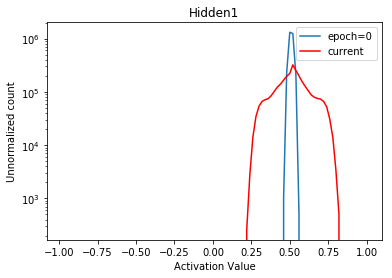

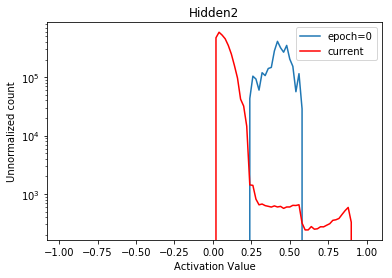

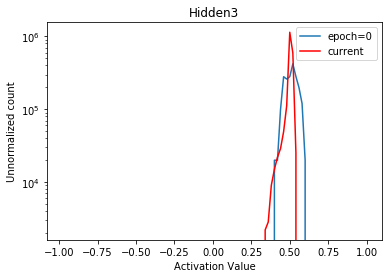

In [0]:
for j in range(len(out_layers)): 
  for i in range(0,int(len(activ_histo[0])),50):
    hist_in = activ_histo[j][i] # [0] is the first epoch's activation
    bins_in = activ_bins[j][i]  
    width_init = 0.7 * (bins_in[1] - bins_in[0])/2
    center_init = (bins_in[:-1] + bins_in[1:]) / 2
    plt.plot(bins_in[1:],hist_in,label = 'epoch='+str(i))
    
  hist_curr = activ_histo[j][-1] # [-1] is the most recent epoch activations
  bins_curr = activ_bins[j][-1]  
  width_curr = 0.7 * (bins_curr[1] - bins_curr[0])/2
  center_curr = (bins_curr[:-1] + bins_curr[1:]) / 2
  plt.plot(bins_curr[1:],hist_curr,label = 'current', color='r')
  
  plt.legend()
  plt.title("Hidden"+str(j+1))
  plt.ylabel('Unnormalized count')
  plt.yscale('log')
  plt.xlabel('Activation Value')
  plt.show()
  

#### Cost function:
  as per usual

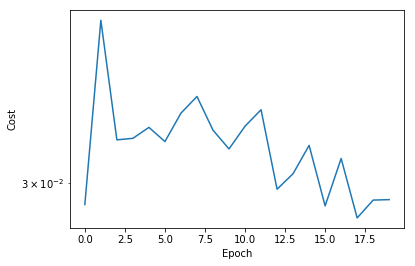

In [0]:
plt.plot(cost)
plt.yscale('log')
plt.ylabel('Cost')
#plt.xscale('log')
plt.xlabel('Epoch')
plt.show()

#### Percentiles:
  plot the xth (5th and 98th in this case) percentile of the activation histograms in order to identify if a layer is saturating high or low

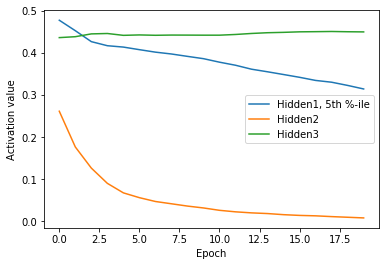

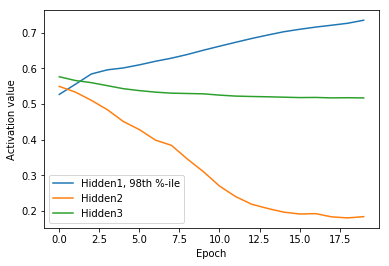

In [0]:
# to plot the various percentiles of a single layer
#plt.plot(activ_pctsT[1:,2,0], label=' 5th percentile, Hidden3 (top hidden)')
#plt.plot(activ_pctsT[1:,2,1], label='25th percentile')
#plt.plot(activ_pctsT[1:,2,2], label='50th percentile')
#plt.plot(activ_pctsT[1:,2,3], label='75th percentile')
#plt.plot(activ_pctsT[1:,2,4], label='98th percentile')
# to plot the 5th percentile of each hidden layer
plt.plot(activ_pctsT[1:,0,0], label='Hidden1, 5th %-ile')
plt.plot(activ_pctsT[1:,1,0], label='Hidden2')
plt.plot(activ_pctsT[1:,2,0], label='Hidden3')
plt.legend()
plt.ylabel('Activation value')
plt.xlabel('Epoch')
plt.show()
# to plot the 98th percentile of each hidden layer
plt.plot(activ_pctsT[1:,0,4], label='Hidden1, 98th %-ile')
plt.plot(activ_pctsT[1:,1,4], label='Hidden2')
plt.plot(activ_pctsT[1:,2,4], label='Hidden3')
plt.legend()
plt.ylabel('Activation value')
plt.xlabel('Epoch')
plt.show()

In [0]:
from keras.utils import plot_model
plot_model(net, to_file='model.png') ## this shows you the network layer layout
plot_model(net, show_shapes=True, to_file='model-1.png') # adds I/O vector sizes
plot_model(net, show_shapes=True, to_file='model-2.png')

#### graph F(x,y) data as an image on validation data:
  only works for F(x,y) and single image compression training types

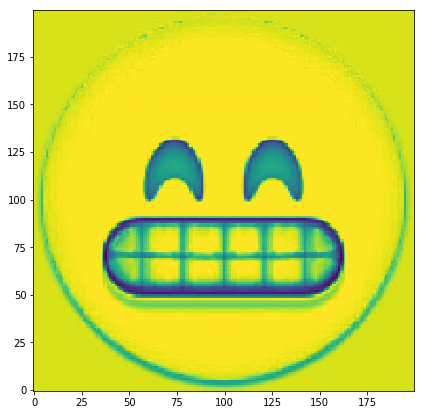

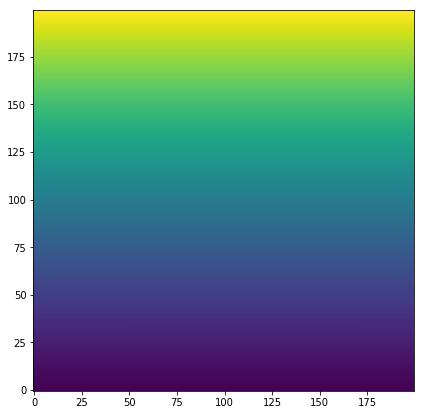

In [0]:
y_out = net.predict_on_batch(val_y_in)

y_2Dn=reshape(val_y_targ,[M,M])
plt.figure(figsize=[7,7])
plt.imshow(y_2Dn,origin='lower')
plt.show()

y_2D=reshape(y_out,[M,M])
plt.figure(figsize=[7,7])
plt.imshow(y_2D,origin='lower')
plt.show()